In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

import xgboost as xgb

import torch
import torch.nn as nn
import torch.optim as optim

import shap

In [3]:
!pip install kagglehub

In [4]:
import kagglehub
import os
import pandas as pd

path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

csv_path = os.path.join(path, "creditcard.csv")
df = pd.read_csv(csv_path)

df.head()

Using Colab cache for faster access to the 'creditcardfraud' dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
0    284315
1       492
Name: count, dtype: int64


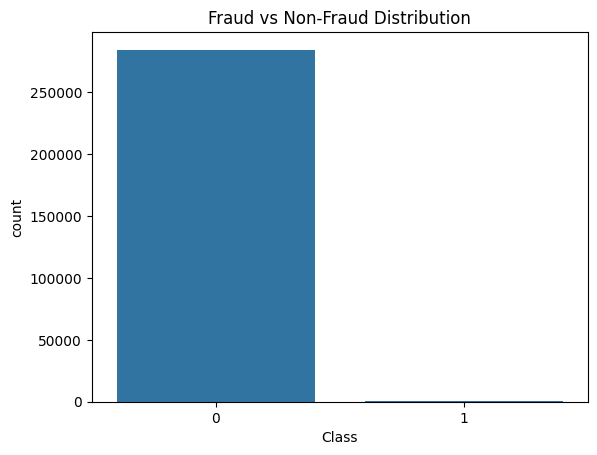

In [5]:
print(df['Class'].value_counts())

sns.countplot(x='Class', data=df)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

In [6]:
X = df.drop('Class', axis=1)
y = df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

XGBoost Model (Advanced Classical ML)

In [7]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=99,   # handles imbalance
    eval_metric='auc'
)

xgb_model.fit(X_train, y_train)

xgb_preds = xgb_model.predict(X_test)

print(classification_report(y_test, xgb_preds))
print("ROC-AUC Score:", roc_auc_score(y_test, xgb_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.82      0.84        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9080577503933481


Confusion Matrix

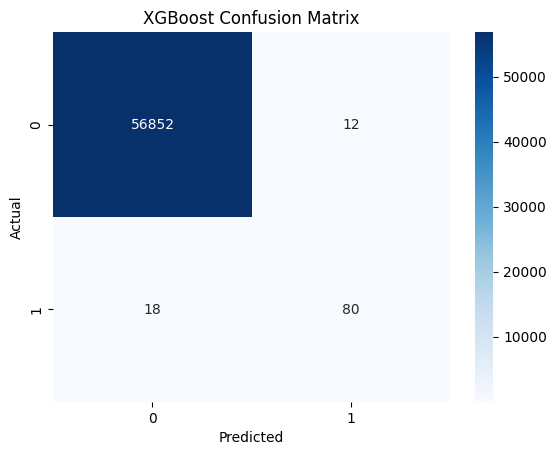

In [8]:
cm = confusion_matrix(y_test, xgb_preds)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()

Deep Neural Network (PyTorch)

In [9]:
class FraudNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dnn = FraudNet(X_train.shape[1]).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(dnn.parameters(), lr=0.001)

Train Deep Learning Model

In [10]:
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)

for epoch in range(20):
    optimizer.zero_grad()
    outputs = dnn(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.7292
Epoch 2, Loss: 0.6944
Epoch 3, Loss: 0.6606
Epoch 4, Loss: 0.6278
Epoch 5, Loss: 0.5956
Epoch 6, Loss: 0.5643
Epoch 7, Loss: 0.5334
Epoch 8, Loss: 0.5030
Epoch 9, Loss: 0.4731
Epoch 10, Loss: 0.4440
Epoch 11, Loss: 0.4154
Epoch 12, Loss: 0.3872
Epoch 13, Loss: 0.3601
Epoch 14, Loss: 0.3338
Epoch 15, Loss: 0.3084
Epoch 16, Loss: 0.2839
Epoch 17, Loss: 0.2609
Epoch 18, Loss: 0.2390
Epoch 19, Loss: 0.2185
Epoch 20, Loss: 0.1993


Evaluate DNN

In [11]:
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    preds = dnn(X_test_t)
    preds = (preds.cpu().numpy() > 0.5).astype(int)

print(classification_report(y_test, preds))
print("ROC-AUC Score:", roc_auc_score(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model Explainability (SHAP)

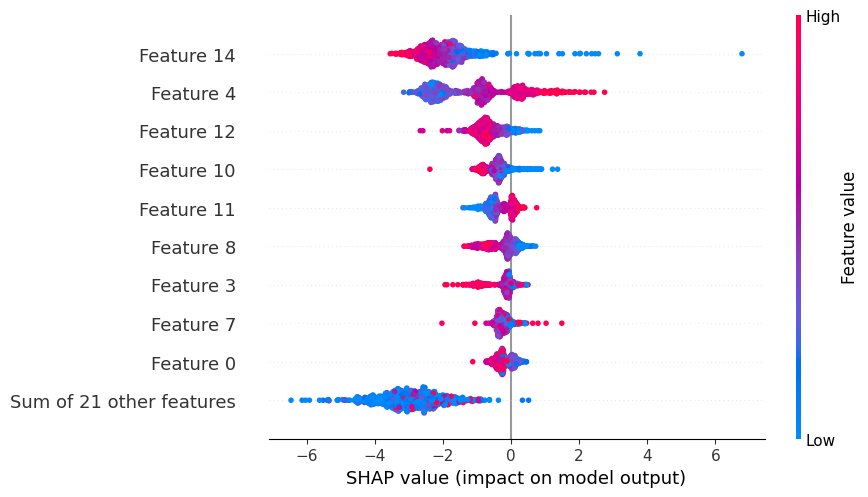

In [12]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train[:1000])

shap.plots.beeswarm(shap_values)